In [1]:
#!pip install ultralytics

In [2]:
import ultralytics
ultralytics.__version__

'8.2.88'

In [3]:
import os
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*

model=YOLO('yolov8s.pt')

In [4]:
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
              'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [5]:
tracker=Tracker()
count=0

In [6]:
cap=cv2.VideoCapture('/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/highway.mp4')

In [7]:
import os  # Add this import to resolve the NameError
import cv2
import time
import pandas as pd

down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    # if count % 2 != 0:
    #     continue
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            list.append([x1, y1, x2, y2])
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
            down[id] = time.time()  # current time when vehicle touches the first line
        if id in down:
            if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
                elapsed_time = time.time() - down[id]  # current time when vehicle touches the second line
                if counter_down.count(id) == 0:
                    counter_down.append(id)
                    distance = 10  # meters
                    a_speed_ms = distance / elapsed_time
                    a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh)) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

        ##### going UP blue line #####
        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
            up[id] = time.time()
        if id in up:
            if red_line_y < (cy + offset) and red_line_y > (cy - offset):
                elapsed1_time = time.time() - up[id]
                if counter_up.count(id) == 0:
                    counter_up.append(id)
                    distance1 = 10  # meters (Distance between the 2 lines is 10 meters)
                    a_speed_ms1 = distance1 / elapsed1_time
                    a_speed_kh1 = a_speed_ms1 * 3.6
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh1)) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, 'Red Line', (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, 'Blue Line', (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, 'Going Down - ' + str(len(counter_down)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, 'Going Up - ' + str(len(counter_up)), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 320x640 8 cars, 2 trucks, 349.2ms
Speed: 2.4ms preprocess, 349.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 417.0ms
Speed: 3.2ms preprocess, 417.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 2 trucks, 197.5ms
Speed: 3.9ms preprocess, 197.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 2 trucks, 321.8ms
Speed: 3.2ms preprocess, 321.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 233.9ms
Speed: 16.2ms preprocess, 233.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 290.1ms
Speed: 12.4ms preprocess, 290.1ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 222.8ms
Speed: 2.4ms preprocess, 222.8ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 214.3ms
Speed: 2

Below code the frame rate is kept high ****************************

In [ ]:
import os
import cv2
import time
import pandas as pd

down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

# Initialize video capture
video_path = '/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/highway.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video is opened successfully
if not cap.isOpened():
    print("Error: Unable to open video")
    exit()

# Get the frame rate of the input video
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, fps, (1020, 500))

frame_skip = 5  # Adjust to skip more frames
count = 0  # Initialize the frame counter

# Initialize the OpenCV window
cv2.namedWindow("frames", cv2.WINDOW_NORMAL)  # Allow window resizing

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1

    # Skip frames to reduce processing load
    if count % frame_skip != 0:
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Start processing the current frame
    start_time = time.time()  # Track time to process frame

    # Assuming your model is initialized correctly before this
    results = model.predict(frame)  # Ensure model is loaded
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            list.append([x1, y1, x2, y2])

    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int((x3 + x4) / 2)
        cy = int((y3 + y4) / 2)

        # Vehicle going DOWN
        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
            down[id] = time.time()  # When vehicle touches the first line
        if id in down:
            if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
                elapsed_time = time.time() - down[id]
                if counter_down.count(id) == 0:
                    counter_down.append(id)
                    distance = 10  # meters
                    a_speed_ms = distance / elapsed_time
                    a_speed_kh = a_speed_ms * 3.6  # Convert to kilometers per hour
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh)) + ' Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

        # Vehicle going UP
        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
            up[id] = time.time()
        if id in up:
            if red_line_y < (cy + offset) and red_line_y > (cy - offset):
                elapsed1_time = time.time() - up[id]
                if counter_up.count(id) == 0:
                    counter_up.append(id)
                    distance1 = 10  # meters
                    a_speed_ms1 = distance1 / elapsed1_time
                    a_speed_kh1 = a_speed_ms1 * 3.6
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh1)) + ' Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

    # Drawing and updating frame text
    text_color = (0, 0, 0)
    yellow_color = (0, 255, 255)
    red_color = (0, 0, 255)
    blue_color = (255, 0, 0)

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, red_line_y), (774, red_line_y), red_color, 2)
    cv2.putText(frame, 'Red Line', (172, red_line_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, blue_line_y), (927, blue_line_y), blue_color, 2)
    cv2.putText(frame, 'Blue Line', (8, blue_line_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Display counts
    cv2.putText(frame, 'Going Down - ' + str(len(counter_down)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, 'Going Up - ' + str(len(counter_up)), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    # Show processed frame
    cv2.imshow("frames", frame)
    
    # Limit window refresh rate
    if cv2.waitKey(100) & 0xFF == 27:  # Press 'Esc' to exit
        break

    print(f"Processed frame in {time.time() - start_time} seconds")

cap.release()
out.release()
cv2.destroyAllWindows()


Below Code analyse both Speed and and if any vilotion is adding in detectd frames images

In [10]:
import os
import cv2
import time
import pandas as pd

down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6
# Initialize video capture
video_path = '/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/highway.mp4'
cap = cv2.VideoCapture(video_path)
# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            list.append([x1, y1, x2, y2])
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
            down[id] = time.time()  # current time when vehicle touches the first line

        if id in down:
            if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
                elapsed_time = time.time() - down[id]  # current time when vehicle touches the second line
                if counter_down.count(id) == 0:
                    counter_down.append(id)
                    distance = 10  # meters
                    a_speed_ms = distance / elapsed_time
                    a_speed_kh = a_speed_ms * 3.6  # Convert to km/h
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh)) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

                    # Save photo if speed is above 100 km/h
                    if a_speed_kh > 100:
                        frame_filename = f'detected_frames/speeding_vehicle_{id}_{count}.jpg'
                        cv2.imwrite(frame_filename, frame)

        ##### going UP blue line #####
        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
            up[id] = time.time()
        if id in up:
            if red_line_y < (cy + offset) and red_line_y > (cy - offset):
                elapsed1_time = time.time() - up[id]
                if counter_up.count(id) == 0:
                    counter_up.append(id)
                    distance1 = 10  # meters (Distance between the 2 lines is 10 meters)
                    a_speed_ms1 = distance1 / elapsed1_time
                    a_speed_kh1 = a_speed_ms1 * 3.6
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh1)) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

                    # Save photo if speed is above 100 km/h
                    if a_speed_kh1 > 100:
                        frame_filename = f'detected_frames/speeding_vehicle_{id}_{count}.jpg'
                        cv2.imwrite(frame_filename, frame)

    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, 'Red Line', (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, 'Blue Line', (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, 'Going Down - ' + str(len(counter_down)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, 'Going Up - ' + str(len(counter_up)), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # Press Esc to exit
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 320x640 8 cars, 2 trucks, 274.5ms
Speed: 6.3ms preprocess, 274.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 329.2ms
Speed: 2.2ms preprocess, 329.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 2 trucks, 236.1ms
Speed: 8.4ms preprocess, 236.1ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 2 trucks, 249.6ms
Speed: 4.6ms preprocess, 249.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 300.1ms
Speed: 8.4ms preprocess, 300.1ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 277.8ms
Speed: 6.1ms preprocess, 277.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 244.9ms
Speed: 2.7ms preprocess, 244.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 321.7ms
Speed: 3.8

In [11]:
import os
import cv2
import time
import pandas as pd

down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Initialize video capture
video_path = '/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/highway.mp4'
cap = cv2.VideoCapture(video_path)

# Create folders to save frames if they don't exist
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

if not os.path.exists('license_plates'):
    os.makedirs('license_plates')

# Video writer setup
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

# Initialize video capture (Ensure you initialize cap somewhere above, e.g., cap = cv2.VideoCapture('path_to_video'))
# For the demonstration, ensure 'cap' is correctly set to your video source
# Example: cap = cv2.VideoCapture('/mnt/data/highway.mp4')

count = 0  # Initialize the frame counter

while True:
    ret, frame = cap.read()
    if not ret:
        break

    count += 1
    frame = cv2.resize(frame, (1020, 500))

    # Assuming model and tracker objects are defined and properly set up
    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    vehicle_list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            vehicle_list.append([x1, y1, x2, y2])

    bbox_id = tracker.update(vehicle_list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int((x3 + x4) / 2)
        cy = int((y3 + y4) / 2)

        # Check vehicles crossing the red line
        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
            down[id] = time.time()

        if id in down:
            if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
                elapsed_time = time.time() - down[id]
                if counter_down.count(id) == 0:
                    counter_down.append(id)
                    distance = 10  # meters
                    a_speed_ms = distance / elapsed_time
                    a_speed_kh = a_speed_ms * 3.6  # Convert to km/h
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh)) + ' Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

                    # Save photo if speed is above 5 km/h
                    if a_speed_kh > 5:
                        frame_filename = f'license_plates/speeding_vehicle_{id}_{count}.jpg'
                        cv2.imwrite(frame_filename, frame)

        # Check vehicles crossing the blue line
        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
            up[id] = time.time()

        if id in up:
            if red_line_y < (cy + offset) and red_line_y > (cy - offset):
                elapsed1_time = time.time() - up[id]
                if counter_up.count(id) == 0:
                    counter_up.append(id)
                    distance1 = 10  # meters
                    a_speed_ms1 = distance1 / elapsed1_time
                    a_speed_kh1 = a_speed_ms1 * 3.6  # Convert to km/h
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh1)) + ' Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

                    # Save photo if speed is above 5 km/h
                    if a_speed_kh1 > 5:
                        frame_filename = f'license_plates/speeding_vehicle_{id}_{count}.jpg'
                        cv2.imwrite(frame_filename, frame)

    # Draw text and lines on the frame
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)
    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, 'Red Line', (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, 'Blue Line', (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, 'Going Down - ' + str(len(counter_down)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, 'Going Up - ' + str(len(counter_up)), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # Press Esc to exit
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 320x640 8 cars, 2 trucks, 219.0ms
Speed: 9.9ms preprocess, 219.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 252.0ms
Speed: 5.3ms preprocess, 252.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 2 trucks, 189.9ms
Speed: 3.6ms preprocess, 189.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 2 trucks, 187.5ms
Speed: 2.2ms preprocess, 187.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 192.9ms
Speed: 5.0ms preprocess, 192.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 189.2ms
Speed: 4.7ms preprocess, 189.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 189.5ms
Speed: 1.7ms preprocess, 189.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 188.8ms
Speed: 1.6

In [12]:
#BELOW conatain all the adavancment code Helmet

In [7]:
import cv2
import time
import os
import pandas as pd
from ultralytics import YOLO
from tracker import Tracker
import easyocr  # For OCR

# Initialize models
model = YOLO('yolov8s.pt')  # Vehicle detection model
helmet_model_path = '/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/best.pt'  # Path to your helmet detection model

# Check if the helmet model file exists
if not os.path.isfile(helmet_model_path):
    raise FileNotFoundError(f"Model file not found: {helmet_model_path}")

helmet_model = YOLO(helmet_model_path)  # Load the pre-trained helmet detection model
reader = easyocr.Reader(['en'])  # Initialize OCR

# Class list and tracker initialization
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
              'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
              'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
              'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
              'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
              'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
              'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
              'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']
tracker = Tracker()

# Load video
cap = cv2.VideoCapture('/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/Helmet and Number Plate Detection and Recognition - Advanced Deep Learning Project - with code.mp4')

# Violation counters and storage
violations = []
down = {}

# Define lines for checking speed
red_line_y = 198
blue_line_y = 268
speed_limit = 50  # Speed limit in km/h

# Prepare CSV file for recording violations
csv_filename = 'violations.csv'
csv_columns = ['License Plate', 'Violation', 'Fine (INR)']
if not os.path.exists(csv_filename):
    pd.DataFrame(columns=csv_columns).to_csv(csv_filename, index=False)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame
    frame = cv2.resize(frame, (1020, 500))
    
    # Run YOLO detection for vehicles
    results = model.predict(frame)
    detections = results[0].boxes.data.detach().cpu().numpy()

    # Track vehicles
    bboxes = []
    for det in detections:
        x1, y1, x2, y2, score, class_id = map(int, det[:6])
        class_name = class_list[class_id]
        if class_name in ['car', 'motorcycle']:
            bboxes.append([x1, y1, x2, y2])

    tracked_vehicles = tracker.update(bboxes)

    for vehicle in tracked_vehicles:
        x1, y1, x2, y2, vehicle_id = vehicle
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        # Initialize speed variable
        speed = 0

        # Check speed and record if over the limit
        if red_line_y < cy < red_line_y + 10:
            down[vehicle_id] = time.time()
        if vehicle_id in down and blue_line_y < cy < blue_line_y + 10:
            elapsed = time.time() - down[vehicle_id]
            if elapsed > 0:  # Avoid division by zero
                speed = (10 / elapsed) * 3.6
                if speed > speed_limit:
                    license_plate = reader.readtext(frame[y1:y2, x1:x2])
                    license_text = license_plate[0][-2] if license_plate else "Unknown"
                    violations.append({'License Plate': license_text, 'Violation': 'Speeding', 'Fine (INR)': 1000})

        # Detect helmets and record if absent
        helmet_results = helmet_model.predict(frame[y1:y2, x1:x2])
        print(helmet_results)  # Debugging line to check results
        if isinstance(helmet_results, list) and len(helmet_results) > 0:
            helmet_present = any('helmet' in result.names for result in helmet_results)
        else:
            helmet_present = False

        if not helmet_present and 'motorcycle' in class_list:
            license_plate = reader.readtext(frame[y1:y2, x1:x2])
            license_text = license_plate[0][-2] if license_plate else "Unknown"
            violations.append({'License Plate': license_text, 'Violation': 'No Helmet', 'Fine (INR)': 500})

        # Draw bounding boxes and speed
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {vehicle_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        if vehicle_id in down:
            speed_display = int(speed) if speed > speed_limit else 0
            cv2.putText(frame, f'Speed: {speed_display} km/h', (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
    
    # Display the frame with annotations
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Save violations to CSV
if violations:
    pd.DataFrame(violations).to_csv(csv_filename, mode='a', header=False, index=False)

cap.release()
cv2.destroyAllWindows()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 320x640 2 persons, 1 backpack, 1 handbag, 1 suitcase, 249.1ms
Speed: 2.5ms preprocess, 249.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 1 motorcycle, 377.5ms
Speed: 2.5ms preprocess, 377.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 416x384 1 helmet, 93.6ms
Speed: 1.6ms preprocess, 93.6ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 384)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'helmet', 1: 'no_helmet'}
obb: None
orig_img: array([[[110,  59,  34],
        [109,  59,  32],
        [109,  59,  31],
        ...,
        [152, 130, 113],
        [168, 146, 129],
        [165, 151, 139]],

       [[110,  59,  34],
        [109,  59,  32],
        [109,  59,  31],
        ...,
        [153, 131, 114],
        [168, 146, 129],
        [164, 151, 138]],

       [[114,  59,  34],
        [112,  59, 

In [8]:
import os
import cv2
import time
import pandas as pd
from ultralytics import YOLO
from tracker import Tracker  # Ensure you have a tracker.py with a Tracker class
import easyocr  # For OCR

# ==================== Configuration ====================

# Paths to models
VEHICLE_MODEL_PATH = 'yolov8s.pt'  # Path to YOLO vehicle detection model
HELMET_MODEL_PATH = '/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/best.pt'  # Path to helmet detection model

# Video paths
INPUT_VIDEO_PATH = '/home/arya/Desktop/Vs Code/websec/Final/Speed-detection-of-vehicles/Helmet and Number Plate Detection and Recognition - Advanced Deep Learning Project - with code.mp4'
OUTPUT_VIDEO_PATH = 'output.avi'

# CSV for violations
CSV_FILENAME = 'violations.csv'
CSV_COLUMNS = ['Timestamp', 'License Plate', 'Violation', 'Fine (INR)']

# Detection parameters
SPEED_LIMIT_KMH = 50  # Speed limit in km/h
DISTANCE_BETWEEN_LINES_METERS = 10  # Distance between the two lines in meters

# Line positions (y-coordinates)
RED_LINE_Y = 198
BLUE_LINE_Y = 268
OFFSET = 6  # Tolerance in pixels

# Frame dimensions
FRAME_WIDTH = 1020
FRAME_HEIGHT = 500

# ==================== Initialize Components ====================

# Initialize YOLO models
vehicle_model = YOLO(VEHICLE_MODEL_PATH)
if not os.path.isfile(HELMET_MODEL_PATH):
    raise FileNotFoundError(f"Helmet model file not found: {HELMET_MODEL_PATH}")
helmet_model = YOLO(HELMET_MODEL_PATH)

# Initialize OCR
reader = easyocr.Reader(['en'])

# Initialize Tracker
tracker = Tracker()

# Class list (ensure it matches your YOLO model's classes)
CLASS_LIST = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

# Initialize video capture
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
if not cap.isOpened():
    raise IOError(f"Cannot open video file: {INPUT_VIDEO_PATH}")

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, 20.0, (FRAME_WIDTH, FRAME_HEIGHT))

# Initialize CSV
if not os.path.exists(CSV_FILENAME):
    pd.DataFrame(columns=CSV_COLUMNS).to_csv(CSV_FILENAME, index=False)

# Initialize variables for speed detection
down = {}  # Vehicle ID and timestamp when crossing red line
counter_down = []  # List of vehicle IDs that have crossed red then blue line
up = {}  # Vehicle ID and timestamp when crossing blue line
counter_up = []  # List of vehicle IDs that have crossed blue then red line

# Initialize frame count
count = 0

# Create folders to save detected frames and license plates
DETECTED_FRAMES_DIR = 'detected_frames'
LICENSE_PLATES_DIR = 'license_plates'
if not os.path.exists(DETECTED_FRAMES_DIR):
    os.makedirs(DETECTED_FRAMES_DIR)
if not os.path.exists(LICENSE_PLATES_DIR):
    os.makedirs(LICENSE_PLATES_DIR)

# ==================== Helper Functions ====================

def log_violation(timestamp, license_plate, violation, fine):
    """Logs the violation to the CSV file."""
    df = pd.DataFrame([{
        'Timestamp': timestamp,
        'License Plate': license_plate,
        'Violation': violation,
        'Fine (INR)': fine
    }])
    df.to_csv(CSV_FILENAME, mode='a', header=False, index=False)

def detect_license_plate(frame, x1, y1, x2, y2, vehicle_id):
    """Detects and returns the license plate text using OCR and saves the license plate image."""
    roi = frame[y1:y2, x1:x2]
    license_plate = reader.readtext(roi)
    if license_plate:
        plate_text = license_plate[0][-2]  # Assuming the second last element is the text
        # Save the license plate image
        plate_image_path = os.path.join(LICENSE_PLATES_DIR, f'vehicle_{vehicle_id}_plate.jpg')
        cv2.imwrite(plate_image_path, roi)
        return plate_text
    return "Unknown"

def detect_helmet(frame, x1, y1, x2, y2):
    """Detects if a helmet is present in the given region."""
    roi = frame[y1:y2, x1:x2]
    results = helmet_model.predict(roi)
    if results and len(results) > 0:
        for result in results:
            if 'helmet' in result.names:
                return True
    return False

# ==================== Main Processing Loop ====================

while True:
    ret, frame = cap.read()
    if not ret:
        break

    count += 1

    # Resize frame
    frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT))

    # Run YOLO detection for vehicles
    results = vehicle_model.predict(frame)
    detections = results[0].boxes.data.cpu().numpy() if results[0].boxes.data is not None else []

    # Prepare bounding boxes for tracker
    bboxes = []
    for det in detections:
        x1, y1, x2, y2, score, class_id = det[:6]
        class_id = int(class_id)
        class_name = CLASS_LIST[class_id] if class_id < len(CLASS_LIST) else 'Unknown'
        if class_name in ['car', 'motorcycle']:  # Process only cars and motorcycles
            # Calculate width and height from (x1, y1, x2, y2)
            w = x2 - x1
            h = y2 - y1
            bboxes.append([int(x1), int(y1), int(w), int(h)])  # Pass only the bounding box coordinates

    # Update tracker
    tracked_vehicles = tracker.update(bboxes)

    # Process each tracked vehicle
    for vehicle in tracked_vehicles:
        x1, y1, w, h, vehicle_id = vehicle
        cx = int((x1 + x1 + w) // 2)
        cy = int((y1 + y1 + h) // 2)

        # Speed Detection
        speed = 0
        current_time = time.time()

        # Check if vehicle crosses the red line
        if RED_LINE_Y - OFFSET < cy < RED_LINE_Y + OFFSET:
            down[vehicle_id] = current_time

        # Check if vehicle crosses the blue line for speed calculation
        if vehicle_id in down and BLUE_LINE_Y - OFFSET < cy < BLUE_LINE_Y + OFFSET:
            elapsed_time = current_time - down[vehicle_id]
            if elapsed_time > 0:
                speed = (DISTANCE_BETWEEN_LINES_METERS / elapsed_time) * 3.6  # Convert m/s to km/h
                if speed > SPEED_LIMIT_KMH and vehicle_id not in counter_down:
                    license_plate = detect_license_plate(frame, x1, y1, x1+w, y1+h, vehicle_id)
                    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(current_time))
                    log_violation(timestamp, license_plate, 'Speeding', 1000)
                    counter_down.append(vehicle_id)

        # Helmet Detection for Motorcycles
        if class_name == 'motorcycle':
            helmet_present = detect_helmet(frame, x1, y1, x1 + w, y1 + h)  # Detect helmet once
            if not helmet_present and vehicle_id not in counter_down:
                # Only log and extract license plate if no helmet is detected
                license_plate = detect_license_plate(frame, x1, y1, x1+w, y1+h, vehicle_id)
                timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(current_time))
                log_violation(timestamp, license_plate, 'No Helmet', 500)
                counter_down.append(vehicle_id)  # Prevent multiple logging

            # Draw bounding box and annotations
            cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {vehicle_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, 'Helmet Detected' if helmet_present else 'No Helmet',
                        (x1, y1 - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Write frame to output video
    out.write(frame)

    # Show the frame
    cv2.imshow('Frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# ==================== Cleanup ====================
cap.release()
out.release()
cv2.destroyAllWindows()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 320x640 2 persons, 1 backpack, 1 handbag, 1 suitcase, 248.5ms
Speed: 2.2ms preprocess, 248.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 3 persons, 1 motorcycle, 290.3ms
Speed: 4.6ms preprocess, 290.3ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 416x384 1 helmet, 102.9ms
Speed: 1.8ms preprocess, 102.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 384)

0: 320x640 1 person, 1 airplane, 199.5ms
Speed: 3.1ms preprocess, 199.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 1 airplane, 213.3ms
Speed: 2.6ms preprocess, 213.3ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 1 motorcycle, 1 airplane, 218.2ms
Speed: 2.1ms preprocess, 218.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 persons, 1 airplane, 1 backpack, 211.0ms
Speed: 2.1ms preprocess, 211.0ms inference, 0.9ms postprocess per image at s

#  detecting objects and drawing 2 lines on image - red and blue

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')


while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy() 
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
                 
    

    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()

# getting the ids of the cars those are touching red line

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time
from datetime import datetime

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')

down={}
up={}

counter_down=[]
counter_up=[]

while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy()  # added this line
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        # cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        # cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        # cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
           
        ''' condition for red line '''
        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
          ''' this if condition is putting the id and the circle on the object when the center of the object touched the red line.'''
          
          down[id]=time.time()  # current time when vehicle touch the red line

          # a = time.time()  
          # dt_object = datetime.fromtimestamp(a)
          # # Format the datetime object as a string in a readable format
          # formatted_time = dt_object.strftime("%Y-%m-%d %H:%M:%S")
          # print("Readable time:", formatted_time)
            
          #This will tell us the travelling direction of the car.
          if id in down:         
           cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
           cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box             
           cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
    
    print("Readable time:", formatted_time)
    print(down)  # printing the id and time of the vehicle when it is touching the red line
    

    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()

# getting the ids of the cars those are touching red line¶

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')

down={}
up={}

counter_down=[]
counter_up=[]

while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy()  # added this line
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        # cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        # cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        # cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
           
    #     ''' condition for red line '''
    #     if red_line_y < (cy + offset) and red_line_y > (cy - offset):
    #       ''' this if condition is putting the id and the circle on the object when the center of the object touched the red line.'''
          
    #       down[id]=time.time()  # current time when vehicle touch the red line
    #       #This will tell us the travelling direction of the car.
    #       if id in down:         
    #        cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
    #        cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box             
    #        cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

    #print(down)  # printing the id and time of the vehicle when it is touching the red line
    

        ''' condition for blue line '''

        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
          up[id]=time.time()   ## current time when vehicle touch the blue line
          if id in up:         
           cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
           cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)        
           counter_up.append(id)        

    print(up)  # printing the id and time of the vehicle when it is touching the red line

    
    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()

# entire code

##### how to calculate speed?

We will use the speed formula which is 
#### speed= distance/time  (distance travelled and elapsed time) 
Elapsed time is the duration between the starting point and the ending point of the movement.

distance = 10 # meters :- distance between the 2 lines(red and blue line) is 10 meters
a_speed_ms = distance / elapsed_time   # ms is meter per second.
We can apply this formula because we have distance and elapsed time.

a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside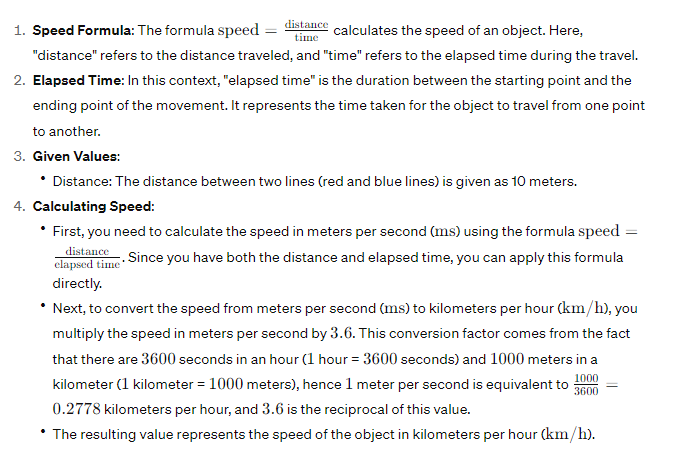

In [ ]:
import cv2
import os
import pandas as pd
from ultralytics import YOLO
from tracker import Tracker

model = YOLO('yolov8s.pt')

cap = cv2.VideoCapture('highway.mp4')
#cap = cv2.VideoCapture('highway_mini.mp4')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

count = 0
tracker = Tracker()
down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    # if count % 2 != 0:
    #     continue
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            list.append([x1, y1, x2, y2])
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        # if red_line_y < (cy + offset) and red_line_y > (cy - offset):
        #     down[id] = cy
        # if id in down:
        #     if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
        #         cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
        #         cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
        #         counter_down.add(id)  # Add ID to set

        # if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
        #     up[id] = cy
        # if id in up:
        #     if red_line_y < (cy + offset) and red_line_y > (cy - offset):
        #         cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
        #         cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
        #         counter_up.add(id)  # Add ID to set


        if red_line_y<(cy+offset) and red_line_y > (cy-offset):
           down[id]=time.time()   # current time when vehichle touch the first line
        if id in down:
          
           if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
             elapsed_time=time.time() - down[id]  # current time when vehicle touch the second line. Also we a re minusing the previous time ( current time of line 1)
             if counter_down.count(id)==0:
                counter_down.append(id)
                distance = 10 # meters - distance between the 2 lines is 10 meters
                a_speed_ms = distance / elapsed_time
                a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh))+'Km/h',(x4,y4 ),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

                
        #####going UP#####     
        if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
           up[id]=time.time()
        if id in up:

           if red_line_y<(cy+offset) and red_line_y > (cy-offset):
             elapsed1_time=time.time() - up[id]
             # formula of speed= distance/time  (distance travelled and elapsed time) Elapsed time is It represents the duration between the starting point and the ending point of the movement.
             if counter_up.count(id)==0:
                counter_up.append(id)      
                distance1 = 10 # meters  (Distance between the 2 lines is 10 meters )
                a_speed_ms1 = distance1 / elapsed1_time
                a_speed_kh1 = a_speed_ms1 * 3.6
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh1))+'Km/h',(x4,y4),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)



    
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, ('Red Line'), (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, ('Blue Line'), (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, ('Going Down - ' + str(len(counter_down))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, ('Going Up - ' + str(len(counter_up))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
    #if cv2.waitKey(0) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()
